# Final Ground Model with Optuna (MLP, LSTM, BiLSTM, CNN-LSTM, Transformer)

## Libraries

In [1]:
import os, json, numpy as np, pandas as pd, matplotlib.pyplot as plt
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, regularizers, backend as K

import optuna
from optuna.samplers import TPESampler
from optuna.pruners import MedianPruner
from optuna.integration import TFKerasPruningCallback
from optuna.storages import JournalStorage
from optuna.storages import JournalFileStorage, JournalFileOpenLock

2025-11-19 15:46:39.832527: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-19 15:46:39.838762: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1763585199.845787  676494 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763585199.848170  676494 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-11-19 15:46:39.856407: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

## Config

In [2]:
SEED = 42
np.random.seed(SEED); tf.random.set_seed(SEED)

DATA_DIR = Path("../data_processed")
OUT_DIR  = Path("../models"); OUT_DIR.mkdir(parents=True, exist_ok=True)
STUDY_DIR= Path("../optuna_studies/05_ground_hpo_optuna_v1"); STUDY_DIR.mkdir(parents=True, exist_ok=True)
ART_DIR  = (OUT_DIR / "optuna_artifacts").resolve(); ART_DIR.mkdir(parents=True, exist_ok=True)

TRAIN_PQ = DATA_DIR / "ground_train_h6.parquet"
VAL_PQ   = DATA_DIR / "ground_val_h6.parquet"
TEST_PQ  = DATA_DIR / "ground_test_h6.parquet"
TARGET   = "y_ghi_h6" 

print("Studies dir:", STUDY_DIR.resolve())
print("Artifacts dir:", ART_DIR)

Studies dir: /mnt/SOLARLAB/E_Ladino/Repo/irradiance-fusion-forecast/optuna_studies/05_ground_hpo_optuna_v1
Artifacts dir: /mnt/SOLARLAB/E_Ladino/Repo/irradiance-fusion-forecast/models/optuna_artifacts


### Data loading and preprocessing

In [3]:
train = pd.read_parquet(TRAIN_PQ).sort_index()
val   = pd.read_parquet(VAL_PQ).sort_index()
test  = pd.read_parquet(TEST_PQ).sort_index()
assert TARGET in train and TARGET in val and TARGET in test, f"{TARGET} missing!"

feat_cols = sorted(list(set(train.columns) & set(val.columns) & set(test.columns) - {TARGET}))
feat_cols = [c for c in feat_cols if pd.api.types.is_numeric_dtype(train[c])]

Xtr_df, ytr = train[feat_cols], train[TARGET]
Xva_df, yva = val[feat_cols],   val[TARGET]
Xte_df, yte = test[feat_cols],  test[TARGET]

scaler = StandardScaler()
Xtr = scaler.fit_transform(Xtr_df)
Xva = scaler.transform(Xva_df)
Xte = scaler.transform(Xte_df)

In [4]:
print(feat_cols)

['Hr', 'azimuth', 'dewpoint_c', 'dewpoint_c_lag1', 'dewpoint_c_lag2', 'dewpoint_c_lag3', 'dewpoint_c_roll_mean_1h', 'dewpoint_c_roll_std_1h', 'doy_cos', 'doy_sin', 'ghi_cs', 'ghi_qc_lag1', 'ghi_qc_lag2', 'ghi_qc_lag3', 'ghi_qc_roll_mean_1h', 'ghi_qc_roll_std_1h', 'hod_cos', 'hod_sin', 'k_ghi_lag1', 'k_ghi_lag2', 'k_ghi_lag3', 'k_ghi_roll_mean_1h', 'k_ghi_roll_std_1h', 'p_hpa', 'temp_c', 'temp_c_lag1', 'temp_c_lag2', 'temp_c_lag3', 'temp_c_roll_mean_1h', 'temp_c_roll_std_1h', 'u_ms', 'u_ms_lag1', 'u_ms_lag2', 'u_ms_lag3', 'u_ms_roll_mean_1h', 'u_ms_roll_std_1h', 'v_ms', 'v_ms_lag1', 'v_ms_lag2', 'v_ms_lag3', 'v_ms_roll_mean_1h', 'v_ms_roll_std_1h', 'wdir_deg', 'wspd_ms', 'zenith']


## Helpers

In [5]:
def _rmse(a,b):
    return float(np.sqrt(mean_squared_error(a,b)))

def skill(y_true, y_pred, y_base):
    return 1.0 - (_rmse(y_true, y_pred) / _rmse(y_true, y_base))

def _build_seq(X_df, y_ser, L):
    """Secuencias sin índice (rápido para objetivos Optuna)."""
    Xv, yv = X_df.values, y_ser.values
    xs, ys = [], []
    for i in range(L-1, len(X_df)):
        block = Xv[i-L+1:i+1]
        if np.isnan(block).any():
            continue
        xs.append(block); ys.append(yv[i])
    return np.asarray(xs, dtype="float32"), np.asarray(ys, dtype="float32")

def build_seq_with_idx(X_df, y_ser, L):
    """Secuencias con índice (para evaluación y plots)."""
    Xv, yv = X_df.values, y_ser.values
    xs, ys, idx = [], [], []
    for i in range(L-1, len(X_df)):
        block = Xv[i-L+1:i+1]
        if np.isnan(block).any():
            continue
        xs.append(block); ys.append(yv[i]); idx.append(X_df.index[i])
    return (np.asarray(xs, dtype="float32"),
            np.asarray(ys, dtype="float32"),
            pd.DatetimeIndex(idx))

def prepare_journal_storage(study_name: str) -> JournalStorage:
    log_path   = STUDY_DIR / f"{study_name}.log"
    lock_path  = STUDY_DIR / f"{study_name}.lock"
    try: lock_path.unlink()
    except FileNotFoundError: pass
    file_storage = JournalFileStorage(str(log_path), lock_obj=JournalFileOpenLock(str(lock_path)))
    return JournalStorage(file_storage)

# def _safe_load_best(study, rebuild_fn=None):
#     """Carga robusta del mejor modelo guardado por el estudio."""
#     p = Path(study.best_trial.user_attrs["model_path"])
#     if not p.exists():
#         # fallback: buscar por nombre
#         hits = list(ART_DIR.rglob(p.name))
#         if hits:
#             p = hits[0]
#         elif rebuild_fn is not None:
#             model = rebuild_fn(study.best_trial.params)
#             p = ART_DIR / "recover.keras"
#             model.save(p)
#         else:
#             raise FileNotFoundError(f"Checkpoint not found: {p}")
#     return tf.keras.models.load_model(p), p

### Models

In [6]:
def build_mlp(input_dim, n1=128, n2=64, do1=0.2, do2=0.1, act="relu", l2w=0.0):
    return tf.keras.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(n1, activation=act, kernel_regularizer=regularizers.l2(l2w)),
        layers.Dropout(do1),
        layers.Dense(n2, activation=act, kernel_regularizer=regularizers.l2(l2w)),
        layers.Dropout(do2),
        layers.Dense(1, dtype="float32"),
    ])

def build_lstm(L, n_feat, units=64, do=0.0):
    inp = layers.Input(shape=(L, n_feat))
    x   = layers.LSTM(units, dropout=do)(inp)
    out = layers.Dense(1, dtype="float32")(x)
    return tf.keras.Model(inp, out)

def build_bilstm(L, n_feat, units=64, do=0.0):
    inp = layers.Input(shape=(L, n_feat))
    x   = layers.Bidirectional(layers.LSTM(units, dropout=do))(inp)
    out = layers.Dense(1, dtype="float32")(x)
    return tf.keras.Model(inp, out)

def build_cnnlstm(L, n_feat, filt=32, ksz=3, pool=1, lstm_units=64, do=0.0):
    inp = layers.Input(shape=(L, n_feat))
    x   = layers.Conv1D(filt, kernel_size=ksz, padding="causal", activation="relu")(inp)
    x   = (layers.MaxPooling1D(pool_size=pool)(x) if pool>1 else layers.Identity()(x))
    x   = layers.LSTM(lstm_units, dropout=do)(x)
    out = layers.Dense(1, dtype="float32")(x)
    return tf.keras.Model(inp, out)

def build_transformer(L, n_feat, d_model=64, heads=4, ff_dim=128, att_do=0.1, do=0.0):
    inp = layers.Input(shape=(L, n_feat))
    x   = layers.Dense(d_model)(inp)
    x2  = layers.MultiHeadAttention(num_heads=heads, key_dim=d_model//heads, dropout=att_do)(x, x)
    x   = layers.Add()([x, x2]); x = layers.LayerNormalization()(x)
    ff  = layers.Dense(ff_dim, activation="relu")(x); ff = layers.Dense(d_model)(ff)
    x   = layers.Add()([x, ff]); x = layers.LayerNormalization()(x)
    x   = layers.GlobalAveragePooling1D()(x)
    x   = layers.Dropout(do)(x)
    out = layers.Dense(1, dtype="float32")(x)
    return tf.keras.Model(inp, out)

### Saving

In [7]:
def _safe_load_best(study):
    """
    Carga robusta: si el best_trial no tiene los nuevos user_attrs (arch, seq_len_used, n_feat),
    los infiere desde study_name / ruta del checkpoint / params del trial.
    Reconstruye la arquitectura y carga PESOS (.weights.h5 o .keras/.h5 legacy).
    """
    ua = dict(study.best_trial.user_attrs) if study.best_trial.user_attrs else {}

    # 1) Localiza el checkpoint
    wpath = None
    if "model_path" in ua:
        p = Path(ua["model_path"])
        if p.exists():
            wpath = p
        else:
            hits = list(ART_DIR.rglob(p.name))
            if hits:
                wpath = hits[0]
    if wpath is None:
        # Fallback: deduce por nombre de estudio
        # Busca archivos 'best.weights.h5' o 'best.keras' en ART_DIR que coincidan con el estudio
        patt = []
        name = (study.study_name or "").lower()
        if "mlp" in name: patt.append("A_mlp_*")
        if "lstm" in name and "bilstm" not in name: patt.append("B_lstm_*")
        if "bilstm" in name: patt.append("B_bilstm_*")
        if "cnn" in name: patt.append("B_cnnlstm_*")
        if "transformer" in name: patt.append("B_transformer_*")
        candidates = []
        for pat in (patt or ["*"]):
            candidates += list(ART_DIR.glob(f"{pat}/best.weights.h5"))
            candidates += list(ART_DIR.glob(f"{pat}/best.keras"))
            candidates += list(ART_DIR.glob(f"{pat}/best.h5"))
        if not candidates:
            raise FileNotFoundError("No checkpoint found for best trial and no user_attrs['model_path'].")
        # Toma el más reciente
        wpath = max(candidates, key=lambda p: p.stat().st_mtime)

    # 2) Deducir 'arch'
    arch = ua.get("arch")
    base = wpath.parent.name.lower()
    sname = (study.study_name or "").lower()
    if arch is None:
        if "mlp" in sname or base.startswith("a_mlp"):
            arch = "mlp"
        elif "bilstm" in sname or "b_bilstm" in base:
            arch = "bilstm"
        elif ("lstm" in sname and "bilstm" not in sname) or "b_lstm" in base:
            arch = "lstm"
        elif "cnn" in sname or "cnn" in base:
            arch = "cnn-lstm"
        elif "transformer" in sname or "transformer" in base:
            arch = "transformer"
        else:
            raise KeyError("Cannot infer 'arch' from study; please re-run trials or set user_attrs.")

    # 3) Deducir L y n_feat para secuenciales
    params = study.best_trial.params
    L = ua.get("seq_len_used") or params.get("seq_len")
    n_feat = ua.get("n_feat")
    if arch != "mlp":
        if L is None:
            # default razonable si faltara
            L = 12
        if n_feat is None:
            # usar el contexto global ya cargado
            n_feat = int(Xtr_s.shape[1])

    # 4) Reconstruye modelo y carga pesos / modelo
    # (acepta tanto weights-only como modelo completo legacy)
    if wpath.suffix in {".keras", ".h5"} and "weights" not in wpath.name:
        # Legacy: modelo completo; cargar con safe_mode desactivado SOLO si confías en el archivo
        import keras
        try:
            keras.config.enable_unsafe_deserialization()
        except Exception:
            pass
        model = tf.keras.models.load_model(wpath, compile=False, safe_mode=False)
        model.compile(optimizer="adam", loss="mse", metrics=["mae"])
        return model, wpath

    # Weights-only (recomendado)
    if arch == "mlp":
        model = build_mlp(
            input_dim=Xtr.shape[1],
            n1=params.get("n1",128),
            n2=params.get("n2",64),
            do1=params.get("do1",0.0),
            do2=params.get("do2",0.0),
            act=params.get("act","relu"),
            l2w=params.get("l2",0.0),
        )
    elif arch == "lstm":
        model = build_lstm(int(L), int(n_feat),
                           units=params.get("units",64),
                           do=params.get("dropout",0.0))
    elif arch == "bilstm":
        model = build_bilstm(int(L), int(n_feat),
                             units=params.get("units",64),
                             do=params.get("dropout",0.0))
    elif arch == "cnn-lstm":
        model = build_cnnlstm(int(L), int(n_feat),
                              filt=params.get("filters",32),
                              ksz=params.get("kernel_size",3),
                              pool=params.get("pool",1),
                              lstm_units=params.get("lstm_units",64),
                              do=params.get("dropout",0.0))
    elif arch == "transformer":
        model = build_transformer(int(L), int(n_feat),
                                  d_model=params.get("d_model",64),
                                  heads=params.get("heads",4),
                                  ff_dim=params.get("ff_dim",128),
                                  att_do=params.get("att_dropout",0.1),
                                  do=params.get("dropout",0.0))
    else:
        raise ValueError(f"Unknown arch: {arch}")

    model.compile(optimizer="adam", loss="mse", metrics=["mae"])
    model.load_weights(str(wpath))
    return model, wpath


## Baseline

In [8]:
base_src = None

# for c in ["k_ghi","k_raw","k_ghi_lag1","k_raw_lag1"]:
#     if c in test.columns: base_src = test[c]; break
# if base_src is None:
#     base_src = pd.Series(np.nanmedian(ytr), index=test.index)

for c in ["ghi_qc","ghi_sg_definitive","ghi_qc_lag1"]:
    if c in test.columns: base_src = test[c]; break
if base_src is None:
    base_src = pd.Series(np.nanmedian(ytr), index=test.index)

y_base = base_src.to_numpy()
print(f"Baseline → RMSE: {_rmse(yte, y_base):.4f} | MAE: {mean_absolute_error(yte, y_base):.4f}")


Baseline → RMSE: 196.2835 | MAE: 102.1871


## Track A - MLP

In [9]:
def objective_mlp(trial: optuna.Trial) -> float:
    K.clear_session()
    n1  = trial.suggest_int("n1", 64, 512, step=64)
    n2  = trial.suggest_int("n2", 32, max(64, n1//2), step=32)
    do1 = trial.suggest_float("do1", 0.0, 0.5)
    do2 = trial.suggest_float("do2", 0.0, 0.5)
    lr  = trial.suggest_float("lr", 1e-4, 5e-3, log=True)
    l2w = trial.suggest_float("l2", 1e-8, 1e-3, log=True)
    act = trial.suggest_categorical("act", ["relu","selu","gelu"])
    bs  = trial.suggest_categorical("batch", [64, 128, 256, 512])
    eps = trial.suggest_int("epochs", 40, 150)

    model = build_mlp(Xtr.shape[1], n1=n1, n2=n2, do1=do1, do2=do2, act=act, l2w=l2w)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                  loss="mse", metrics=["mae"])

    tmp_dir  = ART_DIR / f"A_mlp_t{trial.number:04d}"; tmp_dir.mkdir(parents=True, exist_ok=True)
    tmp_path = (tmp_dir / "best.weights.h5").resolve()

    cbs = [
        callbacks.EarlyStopping(monitor="val_loss", patience=12, restore_best_weights=True, verbose=0),
        callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=6, min_lr=1e-5, verbose=0),
        callbacks.ModelCheckpoint(filepath=str(tmp_path), monitor="val_loss",
                                  save_best_only=True, save_weights_only=True),
        TFKerasPruningCallback(trial, "val_loss"),
    ]

    model.fit(Xtr, ytr, validation_data=(Xva, yva),
              epochs=eps, batch_size=bs, verbose=0, callbacks=cbs)

    yhat = model.predict(Xva, verbose=0).squeeze()
    val_rmse = _rmse(yva, yhat)

    trial.set_user_attr("model_path", str(tmp_path))
    trial.set_user_attr("arch", "mlp")
    trial.set_user_attr("input_dim", Xtr.shape[1])
    return val_rmse

In [10]:
storageA = prepare_journal_storage("ground_trackA_mlp")
studyA = optuna.create_study(direction="minimize",
                             sampler=TPESampler(seed=SEED),
                             pruner=MedianPruner(n_startup_trials=8, n_warmup_steps=5),
                             study_name="ground_trackA_mlp",
                             storage=storageA, load_if_exists=True)
print("Running Study A (MLP)…")
studyA.optimize(objective_mlp, n_trials=40, show_progress_bar=True)

best_mlp, bestA_path = _safe_load_best(studyA)
yhatA = best_mlp.predict(Xte, verbose=0).squeeze()
print("Best MLP params:", studyA.best_trial.params)
print(f"MLP test → RMSE: {_rmse(yte, yhatA):.4f} | MAE: {mean_absolute_error(yte, yhatA):.4f} | R2: {r2_score(yte, yhatA):.4f} | Skill: {skill(yte, yhatA, y_base):.3f}")

/tmp/ipykernel_676494/3240221310.py:36: FutureWarning: The import path :class:`~optuna.storages.JournalFileOpenLock` has been deprecated in v4.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v4.0.0. Use :class:`~optuna.storages.journal.JournalFileOpenLock` instead.
  file_storage = JournalFileStorage(str(log_path), lock_obj=JournalFileOpenLock(str(lock_path)))
/tmp/ipykernel_676494/3240221310.py:36: FutureWarning: JournalFileStorage has been deprecated in v4.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v4.0.0. Use :class:`~optuna.storages.journal.JournalFileBackend` instead.
  file_storage = JournalFileStorage(str(log_path), lock_obj=JournalFileOpenLock(str(lock_path)))
[I 2025-11-19 15:46:47,458] Using an existing study with name 'ground_trackA_mlp' instead of creating a new one.


Running Study A (MLP)…


  0%|          | 0/40 [00:00<?, ?it/s]

I0000 00:00:1763585212.030226  676494 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 17584 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:01:00.0, compute capability: 8.9
I0000 00:00:1763585213.366499  676630 service.cc:148] XLA service 0x7c399c01aab0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1763585213.366525  676630 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2025-11-19 15:46:53.380825: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1763585213.431116  676630 cuda_dnn.cc:529] Loaded cuDNN version 90101
I0000 00:00:1763585214.644602  676630 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


[I 2025-11-19 15:47:05,133] Trial 46 pruned. Trial was pruned at epoch 7.


2025-11-19 15:47:11.785924: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_48_0', 256 bytes spill stores, 256 bytes spill loads

2025-11-19 15:47:11.831379: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_48_0', 776 bytes spill stores, 724 bytes spill loads

2025-11-19 15:47:12.432322: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_48_0', 260 bytes spill stores, 292 bytes spill loads

2025-11-19 15:47:12.589585: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_48_0', 1044 bytes spill stores, 732 bytes spill loads



[I 2025-11-19 15:47:22,485] Trial 47 pruned. Trial was pruned at epoch 5.
[I 2025-11-19 15:47:42,488] Trial 48 pruned. Trial was pruned at epoch 5.
[I 2025-11-19 15:48:08,235] Trial 49 pruned. Trial was pruned at epoch 15.
[I 2025-11-19 15:48:33,613] Trial 50 pruned. Trial was pruned at epoch 7.
[I 2025-11-19 15:48:49,294] Trial 51 pruned. Trial was pruned at epoch 5.
[I 2025-11-19 15:49:05,868] Trial 52 pruned. Trial was pruned at epoch 5.
[I 2025-11-19 15:50:01,572] Trial 53 finished with value: 129.91637935610737 and parameters: {'n1': 256, 'n2': 96, 'do1': 0.3839648965685951, 'do2': 0.25150335484031106, 'lr': 0.003965090997776624, 'l2': 4.429404772444898e-05, 'act': 'gelu', 'batch': 512, 'epochs': 70}. Best is trial 32 with value: 129.6991561026902.
[I 2025-11-19 15:50:57,837] Trial 54 finished with value: 130.01483539148524 and parameters: {'n1': 320, 'n2': 128, 'do1': 0.1884979853831891, 'do2': 0.3138205158294623, 'lr': 0.002462635028933902, 'l2': 0.00012202518958340676, 'act': '

2025-11-19 16:00:13.802428: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_48_0', 64 bytes spill stores, 64 bytes spill loads



[I 2025-11-19 16:00:22,134] Trial 77 pruned. Trial was pruned at epoch 5.
[I 2025-11-19 16:00:43,272] Trial 78 pruned. Trial was pruned at epoch 10.
[I 2025-11-19 16:00:57,231] Trial 79 pruned. Trial was pruned at epoch 5.
[I 2025-11-19 16:01:38,698] Trial 80 finished with value: 129.8491612891666 and parameters: {'n1': 320, 'n2': 128, 'do1': 0.3734556097011381, 'do2': 0.2792685183278859, 'lr': 0.001944214645345638, 'l2': 3.647323232624319e-05, 'act': 'gelu', 'batch': 128, 'epochs': 64}. Best is trial 74 with value: 129.66827417732142.
[I 2025-11-19 16:02:08,687] Trial 81 finished with value: 130.00402637995487 and parameters: {'n1': 384, 'n2': 160, 'do1': 0.44548879794461194, 'do2': 0.4066756022260002, 'lr': 0.002297689660435896, 'l2': 1.9347153315154744e-05, 'act': 'gelu', 'batch': 512, 'epochs': 49}. Best is trial 74 with value: 129.66827417732142.
[I 2025-11-19 16:02:53,518] Trial 82 finished with value: 129.7529277728445 and parameters: {'n1': 384, 'n2': 160, 'do1': 0.464034689434

/home/e.ladino/miniconda3/envs/e_ladino/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Best MLP params: {'n1': 320, 'n2': 128, 'do1': 0.4860755506545529, 'do2': 0.33702281101431014, 'lr': 0.0037573051304608286, 'l2': 7.0590920479768835e-06, 'act': 'gelu', 'batch': 512, 'epochs': 43}
MLP test → RMSE: 135.0046 | MAE: 66.7116 | R2: 0.7252 | Skill: 0.312


## Track B - Sequentials

### Mods

In [11]:
Xtr_s = pd.DataFrame(Xtr, index=Xtr_df.index, columns=feat_cols)
Xva_s = pd.DataFrame(Xva, index=Xva_df.index, columns=feat_cols)
Xte_s = pd.DataFrame(Xte, index=Xte_df.index, columns=feat_cols)

### LSTM

In [12]:
def objective_lstm(trial: optuna.Trial) -> float:
    K.clear_session()
    L   = trial.suggest_categorical("seq_len", [6, 12, 18, 24])
    u   = trial.suggest_int("units", 32, 128, step=32)
    do  = trial.suggest_float("dropout", 0.0, 0.4)
    lr  = trial.suggest_float("lr", 5e-5, 5e-3, log=True)
    bs  = trial.suggest_categorical("batch", [64, 128, 256])
    eps = trial.suggest_int("epochs", 40, 120)

    Xtr_seq, ytr_seq = _build_seq(Xtr_s, ytr, L)
    Xva_seq, yva_seq = _build_seq(Xva_s, yva, L)
    if min(map(len,[Xtr_seq, Xva_seq])) == 0:
        raise optuna.TrialPruned()

    model = build_lstm(L, Xtr_seq.shape[2], units=u, do=do)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss="mse", metrics=["mae"])

    tmp_dir  = ART_DIR / f"B_lstm_t{trial.number:04d}"; tmp_dir.mkdir(parents=True, exist_ok=True)
    tmp_path = (tmp_dir / "best.weights.h5").resolve()

    cbs = [
        callbacks.EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True, verbose=0),
        callbacks.ModelCheckpoint(filepath=str(tmp_path), monitor="val_loss",
                                  save_best_only=True, save_weights_only=True),
        TFKerasPruningCallback(trial, "val_loss"),
    ]
    model.fit(Xtr_seq, ytr_seq, validation_data=(Xva_seq, yva_seq),
              epochs=eps, batch_size=bs, verbose=0, callbacks=cbs)

    yhat = model.predict(Xva_seq, verbose=0).squeeze()
    val_rmse = _rmse(yva_seq, yhat)

    trial.set_user_attr("model_path", str(tmp_path))
    trial.set_user_attr("arch", "lstm")
    trial.set_user_attr("seq_len_used", L)
    trial.set_user_attr("n_feat", Xtr_s.shape[1])
    return val_rmse

In [13]:
storageB1 = prepare_journal_storage("ground_trackB_lstm")
studyB1 = optuna.create_study(direction="minimize",
                              sampler=TPESampler(seed=SEED),
                              pruner=MedianPruner(n_startup_trials=8, n_warmup_steps=5),
                              study_name="ground_trackB_lstm",
                              storage=storageB1, load_if_exists=True)
print("Running Study B1 (LSTM)…")
studyB1.optimize(objective_lstm, n_trials=40, show_progress_bar=True)

best_lstm, _ = _safe_load_best(studyB1)
bestL1 = studyB1.best_trial.user_attrs["seq_len_used"]
Xte_seq, yte_seq, idx_LSTM = build_seq_with_idx(Xte_s, yte, bestL1)
yhatB1 = best_lstm.predict(Xte_seq, verbose=0).squeeze()
y_base_LSTM = pd.Series(y_base, index=Xte_df.index).reindex(idx_LSTM).to_numpy()
print("Best LSTM params:", studyB1.best_trial.params | {"seq_len": bestL1})
print(f"LSTM test → RMSE: {_rmse(yte_seq, yhatB1):.4f} | MAE: {mean_absolute_error(yte_seq, yhatB1):.4f} | R2: {r2_score(yte_seq, yhatB1):.4f} | Skill: {skill(yte_seq, yhatB1, y_base_LSTM):.3f}")

/tmp/ipykernel_676494/3240221310.py:36: FutureWarning: The import path :class:`~optuna.storages.JournalFileOpenLock` has been deprecated in v4.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v4.0.0. Use :class:`~optuna.storages.journal.JournalFileOpenLock` instead.
  file_storage = JournalFileStorage(str(log_path), lock_obj=JournalFileOpenLock(str(lock_path)))
/tmp/ipykernel_676494/3240221310.py:36: FutureWarning: JournalFileStorage has been deprecated in v4.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v4.0.0. Use :class:`~optuna.storages.journal.JournalFileBackend` instead.
  file_storage = JournalFileStorage(str(log_path), lock_obj=JournalFileOpenLock(str(lock_path)))
[I 2025-11-19 16:04:28,511] Using an existing study with name 'ground_trackB_lstm' instead of creating a new one.


Running Study B1 (LSTM)…


  0%|          | 0/40 [00:00<?, ?it/s]

[I 2025-11-19 16:04:43,307] Trial 40 pruned. Trial was pruned at epoch 5.
[I 2025-11-19 16:05:01,635] Trial 41 pruned. Trial was pruned at epoch 5.
[I 2025-11-19 16:05:21,724] Trial 42 pruned. Trial was pruned at epoch 5.
[I 2025-11-19 16:06:13,347] Trial 43 finished with value: 130.464966262499 and parameters: {'seq_len': 18, 'units': 64, 'dropout': 0.29374080704415834, 'lr': 0.004206793046471318, 'batch': 128, 'epochs': 62}. Best is trial 21 with value: 130.1381627588541.
[I 2025-11-19 16:06:51,219] Trial 44 pruned. Trial was pruned at epoch 15.
[I 2025-11-19 16:07:49,494] Trial 45 finished with value: 130.24841049893854 and parameters: {'seq_len': 18, 'units': 96, 'dropout': 0.3475621659320009, 'lr': 0.004975354780986839, 'batch': 128, 'epochs': 83}. Best is trial 21 with value: 130.1381627588541.
[I 2025-11-19 16:08:05,711] Trial 46 pruned. Trial was pruned at epoch 5.
[I 2025-11-19 16:08:53,658] Trial 47 finished with value: 131.84313892368462 and parameters: {'seq_len': 12, 'unit

/home/e.ladino/miniconda3/envs/e_ladino/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 12 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Best LSTM params: {'seq_len': 24, 'units': 96, 'dropout': 0.3506620760345195, 'lr': 0.0019621779546816296, 'batch': 64, 'epochs': 63}
LSTM test → RMSE: 137.0326 | MAE: 71.6631 | R2: 0.7172 | Skill: 0.303


### BiLSTM

In [14]:
def objective_bilstm(trial: optuna.Trial) -> float:
    K.clear_session()
    L   = trial.suggest_categorical("seq_len", [6, 12, 18, 24])
    u   = trial.suggest_int("units", 32, 128, step=32)
    do  = trial.suggest_float("dropout", 0.0, 0.4)
    lr  = trial.suggest_float("lr", 5e-5, 5e-3, log=True)
    bs  = trial.suggest_categorical("batch", [64, 128, 256])
    eps = trial.suggest_int("epochs", 40, 120)

    Xtr_seq, ytr_seq = _build_seq(Xtr_s, ytr, L)
    Xva_seq, yva_seq = _build_seq(Xva_s, yva, L)
    if min(map(len,[Xtr_seq, Xva_seq])) == 0:
        raise optuna.TrialPruned()

    model = build_bilstm(L, Xtr_seq.shape[2], units=u, do=do)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss="mse", metrics=["mae"])

    tmp_dir  = ART_DIR / f"B_bilstm_t{trial.number:04d}"; tmp_dir.mkdir(parents=True, exist_ok=True)
    tmp_path = (tmp_dir / "best.weights.h5").resolve()

    cbs = [
        callbacks.EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True, verbose=0),
        callbacks.ModelCheckpoint(filepath=str(tmp_path), monitor="val_loss",
                                  save_best_only=True, save_weights_only=True),
        TFKerasPruningCallback(trial, "val_loss"),
    ]
    model.fit(Xtr_seq, ytr_seq, validation_data=(Xva_seq, yva_seq),
              epochs=eps, batch_size=bs, verbose=0, callbacks=cbs)

    yhat = model.predict(Xva_seq, verbose=0).squeeze()
    val_rmse = _rmse(yva_seq, yhat)

    trial.set_user_attr("model_path", str(tmp_path))
    trial.set_user_attr("arch", "bilstm")
    trial.set_user_attr("seq_len_used", L)
    trial.set_user_attr("n_feat", Xtr_s.shape[1])
    return val_rmse

In [15]:
storageB2 = prepare_journal_storage("ground_trackB_bilstm")
studyB2 = optuna.create_study(direction="minimize",
                              sampler=TPESampler(seed=SEED),
                              pruner=MedianPruner(n_startup_trials=8, n_warmup_steps=5),
                              study_name="ground_trackB_bilstm",
                              storage=storageB2, load_if_exists=True)
print("Running Study B2 (BiLSTM)…")
studyB2.optimize(objective_bilstm, n_trials=35, show_progress_bar=True)

best_bi, _ = _safe_load_best(studyB2)
bestL2 = studyB2.best_trial.user_attrs["seq_len_used"]
Xte_seq, yte_seq, idx_BI = build_seq_with_idx(Xte_s, yte, bestL2)
yhatB2 = best_bi.predict(Xte_seq, verbose=0).squeeze()
y_base_BI = pd.Series(y_base, index=Xte_df.index).reindex(idx_BI).to_numpy()
print("Best BiLSTM params:", studyB2.best_trial.params | {"seq_len": bestL2})
print(f"BiLSTM test → RMSE: {_rmse(yte_seq, yhatB2):.4f} | MAE: {mean_absolute_error(yte_seq, yhatB2):.4f} | R2: {r2_score(yte_seq, yhatB2):.4f} | Skill: {skill(yte_seq, yhatB2, y_base_BI):.3f}")

/tmp/ipykernel_676494/3240221310.py:36: FutureWarning: The import path :class:`~optuna.storages.JournalFileOpenLock` has been deprecated in v4.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v4.0.0. Use :class:`~optuna.storages.journal.JournalFileOpenLock` instead.
  file_storage = JournalFileStorage(str(log_path), lock_obj=JournalFileOpenLock(str(lock_path)))
/tmp/ipykernel_676494/3240221310.py:36: FutureWarning: JournalFileStorage has been deprecated in v4.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v4.0.0. Use :class:`~optuna.storages.journal.JournalFileBackend` instead.
  file_storage = JournalFileStorage(str(log_path), lock_obj=JournalFileOpenLock(str(lock_path)))
[I 2025-11-19 16:33:57,690] Using an existing study with name 'ground_trackB_bilstm' instead of creating a new one.


Running Study B2 (BiLSTM)…


  0%|          | 0/35 [00:00<?, ?it/s]

[I 2025-11-19 16:34:16,430] Trial 35 pruned. Trial was pruned at epoch 5.
[I 2025-11-19 16:35:07,110] Trial 36 finished with value: 131.3884834898021 and parameters: {'seq_len': 12, 'units': 96, 'dropout': 0.27035518226392646, 'lr': 0.004931158627318939, 'batch': 128, 'epochs': 42}. Best is trial 21 with value: 130.51208486908405.
[I 2025-11-19 16:35:36,502] Trial 37 pruned. Trial was pruned at epoch 5.
[I 2025-11-19 16:36:24,040] Trial 38 finished with value: 131.34408829958812 and parameters: {'seq_len': 18, 'units': 96, 'dropout': 0.3815068602293172, 'lr': 0.003488804309517061, 'batch': 128, 'epochs': 63}. Best is trial 21 with value: 130.51208486908405.
[I 2025-11-19 16:36:34,445] Trial 39 pruned. Trial was pruned at epoch 5.
[I 2025-11-19 16:36:46,471] Trial 40 pruned. Trial was pruned at epoch 5.
[I 2025-11-19 16:36:53,738] Trial 41 pruned. Trial was pruned at epoch 5.
[I 2025-11-19 16:37:00,094] Trial 42 pruned. Trial was pruned at epoch 5.
[I 2025-11-19 16:37:06,928] Trial 43 p

/home/e.ladino/miniconda3/envs/e_ladino/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Best BiLSTM params: {'seq_len': 18, 'units': 96, 'dropout': 0.17973189731289801, 'lr': 0.004192064318361171, 'batch': 128, 'epochs': 100}
BiLSTM test → RMSE: 137.5014 | MAE: 71.5644 | R2: 0.7152 | Skill: 0.300


### CNN-LSTM

In [16]:
def objective_cnnlstm(trial: optuna.Trial) -> float:
    K.clear_session()
    L     = trial.suggest_categorical("seq_len", [6, 12, 18, 24])
    filt  = trial.suggest_int("filters", 16, 64, step=16)
    ksz   = trial.suggest_categorical("kernel_size", [2,3,5])
    pool  = trial.suggest_categorical("pool", [1,2])
    u     = trial.suggest_int("lstm_units", 32, 128, step=32)
    do    = trial.suggest_float("dropout", 0.0, 0.4)
    lr    = trial.suggest_float("lr", 5e-5, 5e-3, log=True)
    bs    = trial.suggest_categorical("batch", [64, 128, 256])
    eps   = trial.suggest_int("epochs", 40, 120)

    Xtr_seq, ytr_seq = _build_seq(Xtr_s, ytr, L)
    Xva_seq, yva_seq = _build_seq(Xva_s, yva, L)
    if min(map(len,[Xtr_seq, Xva_seq])) == 0:
        raise optuna.TrialPruned()

    model = build_cnnlstm(L, Xtr_seq.shape[2], filt=filt, ksz=ksz, pool=pool, lstm_units=u, do=do)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss="mse", metrics=["mae"])

    tmp_dir  = ART_DIR / f"B_cnnlstm_t{trial.number:04d}"; tmp_dir.mkdir(parents=True, exist_ok=True)
    tmp_path = (tmp_dir / "best.weights.h5").resolve()

    cbs = [
        callbacks.EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True, verbose=0),
        callbacks.ModelCheckpoint(filepath=str(tmp_path), monitor="val_loss",
                                  save_best_only=True, save_weights_only=True),
        TFKerasPruningCallback(trial, "val_loss"),
    ]
    model.fit(Xtr_seq, ytr_seq, validation_data=(Xva_seq, yva_seq),
              epochs=eps, batch_size=bs, verbose=0, callbacks=cbs)

    yhat = model.predict(Xva_seq, verbose=0).squeeze()
    val_rmse = _rmse(yva_seq, yhat)

    trial.set_user_attr("model_path", str(tmp_path))
    trial.set_user_attr("arch", "cnn-lstm")
    trial.set_user_attr("seq_len_used", L)
    trial.set_user_attr("n_feat", Xtr_s.shape[1])
    return val_rmse

In [17]:
storageB3 = prepare_journal_storage("ground_trackB_cnnlstm")
studyB3 = optuna.create_study(direction="minimize",
                              sampler=TPESampler(seed=SEED),
                              pruner=MedianPruner(n_startup_trials=8, n_warmup_steps=5),
                              study_name="ground_trackB_cnnlstm",
                              storage=storageB3, load_if_exists=True)
print("Running Study B3 (CNN-LSTM)…")
studyB3.optimize(objective_cnnlstm, n_trials=35, show_progress_bar=True)

best_cnn, _ = _safe_load_best(studyB3)
bestL3 = studyB3.best_trial.user_attrs["seq_len_used"]
Xte_seq, yte_seq, idx_CNN = build_seq_with_idx(Xte_s, yte, bestL3)
yhatB3 = best_cnn.predict(Xte_seq, verbose=0).squeeze()
y_base_CNN = pd.Series(y_base, index=Xte_df.index).reindex(idx_CNN).to_numpy()
print("Best CNN-LSTM params:", studyB3.best_trial.params | {"seq_len": bestL3})
print(f"CNN-LSTM test → RMSE: {_rmse(yte_seq, yhatB3):.4f} | MAE: {mean_absolute_error(yte_seq, yhatB3):.4f} | R2: {r2_score(yte_seq, yhatB3):.4f} | Skill: {skill(yte_seq, yhatB3, y_base_CNN):.3f}")


/tmp/ipykernel_676494/3240221310.py:36: FutureWarning: The import path :class:`~optuna.storages.JournalFileOpenLock` has been deprecated in v4.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v4.0.0. Use :class:`~optuna.storages.journal.JournalFileOpenLock` instead.
  file_storage = JournalFileStorage(str(log_path), lock_obj=JournalFileOpenLock(str(lock_path)))
/tmp/ipykernel_676494/3240221310.py:36: FutureWarning: JournalFileStorage has been deprecated in v4.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v4.0.0. Use :class:`~optuna.storages.journal.JournalFileBackend` instead.
  file_storage = JournalFileStorage(str(log_path), lock_obj=JournalFileOpenLock(str(lock_path)))
[I 2025-11-19 16:55:49,388] Using an existing study with name 'ground_trackB_cnnlstm' instead of creating a new one.


Running Study B3 (CNN-LSTM)…


  0%|          | 0/35 [00:00<?, ?it/s]

[I 2025-11-19 16:56:38,800] Trial 35 pruned. Trial was pruned at epoch 8.
[I 2025-11-19 16:56:57,493] Trial 36 pruned. Trial was pruned at epoch 5.
[I 2025-11-19 16:57:22,547] Trial 37 pruned. Trial was pruned at epoch 7.
[I 2025-11-19 16:57:36,376] Trial 38 pruned. Trial was pruned at epoch 5.
[I 2025-11-19 16:57:44,907] Trial 39 pruned. Trial was pruned at epoch 5.
[I 2025-11-19 16:58:11,380] Trial 40 pruned. Trial was pruned at epoch 11.
[I 2025-11-19 16:58:24,973] Trial 41 pruned. Trial was pruned at epoch 5.
[I 2025-11-19 16:58:40,325] Trial 42 pruned. Trial was pruned at epoch 5.
[I 2025-11-19 16:59:28,880] Trial 43 finished with value: 131.64718919093943 and parameters: {'seq_len': 18, 'filters': 48, 'kernel_size': 2, 'pool': 1, 'lstm_units': 128, 'dropout': 0.29845532392250707, 'lr': 0.0016861318134381964, 'batch': 64, 'epochs': 69}. Best is trial 11 with value: 131.05451215524783.
[I 2025-11-19 17:00:10,597] Trial 44 finished with value: 131.0934780986453 and parameters: {'seq

/home/e.ladino/miniconda3/envs/e_ladino/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 16 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Best CNN-LSTM params: {'seq_len': 18, 'filters': 64, 'kernel_size': 2, 'pool': 1, 'lstm_units': 128, 'dropout': 0.11784662868173323, 'lr': 0.0019334111731287539, 'batch': 64, 'epochs': 67}
CNN-LSTM test → RMSE: 140.1074 | MAE: 71.5750 | R2: 0.7043 | Skill: 0.287


### Transformer

In [18]:
def objective_transformer(trial: optuna.Trial) -> float:
    K.clear_session()
    L       = trial.suggest_categorical("seq_len", [6, 12, 18, 24])
    d_model = trial.suggest_categorical("d_model", [32, 64, 96, 128])
    heads   = trial.suggest_categorical("heads", [2, 4, 8])
    if d_model % heads != 0:
        raise optuna.TrialPruned()
    ff_dim  = trial.suggest_categorical("ff_dim", [64, 96, 128, 192])
    att_do  = trial.suggest_float("att_dropout", 0.0, 0.3)
    do      = trial.suggest_float("dropout", 0.0, 0.4)
    lr      = trial.suggest_float("lr", 5e-5, 5e-3, log=True)
    bs      = trial.suggest_categorical("batch", [64, 128, 256])
    eps     = trial.suggest_int("epochs", 40, 120)

    Xtr_seq, ytr_seq = _build_seq(Xtr_s, ytr, L)
    Xva_seq, yva_seq = _build_seq(Xva_s, yva, L)
    if min(map(len,[Xtr_seq, Xva_seq])) == 0:
        raise optuna.TrialPruned()

    model = build_transformer(L, Xtr_seq.shape[2], d_model=d_model, heads=heads,
                              ff_dim=ff_dim, att_do=att_do, do=do)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss="mse", metrics=["mae"])

    tmp_dir  = ART_DIR / f"B_transformer_t{trial.number:04d}"; tmp_dir.mkdir(parents=True, exist_ok=True)
    tmp_path = (tmp_dir / "best.weights.h5").resolve()

    cbs = [
        callbacks.EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True, verbose=0),
        callbacks.ModelCheckpoint(filepath=str(tmp_path), monitor="val_loss",
                                  save_best_only=True, save_weights_only=True),
        TFKerasPruningCallback(trial, "val_loss"),
    ]
    model.fit(Xtr_seq, ytr_seq, validation_data=(Xva_seq, yva_seq),
              epochs=eps, batch_size=bs, verbose=0, callbacks=cbs)

    yhat = model.predict(Xva_seq, verbose=0).squeeze()
    val_rmse = _rmse(yva_seq, yhat)

    trial.set_user_attr("model_path", str(tmp_path))
    trial.set_user_attr("arch", "transformer")
    trial.set_user_attr("seq_len_used", L)
    trial.set_user_attr("n_feat", Xtr_s.shape[1])
    return val_rmse

In [19]:
storageB4 = prepare_journal_storage("ground_trackB_transformer")
studyB4 = optuna.create_study(direction="minimize",
                              sampler=TPESampler(seed=SEED),
                              pruner=MedianPruner(n_startup_trials=8, n_warmup_steps=5),
                              study_name="ground_trackB_transformer",
                              storage=storageB4, load_if_exists=True)
print("Running Study B4 (Transformer)…")
studyB4.optimize(objective_transformer, n_trials=40, show_progress_bar=True)

best_tr, _ = _safe_load_best(studyB4)
bestL4 = studyB4.best_trial.user_attrs["seq_len_used"]
Xte_seq, yte_seq, idx_TR = build_seq_with_idx(Xte_s, yte, bestL4)
yhatB4 = best_tr.predict(Xte_seq, verbose=0).squeeze()
y_base_TR = pd.Series(y_base, index=Xte_df.index).reindex(idx_TR).to_numpy()
print("Best Transformer params:", studyB4.best_trial.params | {"seq_len": bestL4})
print(f"Transformer test → RMSE: {_rmse(yte_seq, yhatB4):.4f} | MAE: {mean_absolute_error(yte_seq, yhatB4):.4f} | R2: {r2_score(yte_seq, yhatB4):.4f} | Skill: {skill(yte_seq, yhatB4, y_base_TR):.3f}")


/tmp/ipykernel_676494/3240221310.py:36: FutureWarning: The import path :class:`~optuna.storages.JournalFileOpenLock` has been deprecated in v4.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v4.0.0. Use :class:`~optuna.storages.journal.JournalFileOpenLock` instead.
  file_storage = JournalFileStorage(str(log_path), lock_obj=JournalFileOpenLock(str(lock_path)))
/tmp/ipykernel_676494/3240221310.py:36: FutureWarning: JournalFileStorage has been deprecated in v4.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v4.0.0. Use :class:`~optuna.storages.journal.JournalFileBackend` instead.
  file_storage = JournalFileStorage(str(log_path), lock_obj=JournalFileOpenLock(str(lock_path)))
[I 2025-11-19 17:10:00,697] Using an existing study with name 'ground_trackB_transformer' instead of creating a new one.


Running Study B4 (Transformer)…


  0%|          | 0/40 [00:00<?, ?it/s]

2025-11-19 17:10:08.566865: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_10', 32 bytes spill stores, 32 bytes spill loads

2025-11-19 17:10:24.385965: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_10', 32 bytes spill stores, 32 bytes spill loads



[I 2025-11-19 17:10:25,203] Trial 40 finished with value: 132.1455459427218 and parameters: {'seq_len': 6, 'd_model': 32, 'heads': 2, 'ff_dim': 64, 'att_dropout': 0.06352930452794081, 'dropout': 0.1814604413767954, 'lr': 0.002651334930942296, 'batch': 64, 'epochs': 50}. Best is trial 26 with value: 130.92029272375999.
[I 2025-11-19 17:10:46,900] Trial 41 finished with value: 131.70906325591264 and parameters: {'seq_len': 24, 'd_model': 32, 'heads': 8, 'ff_dim': 96, 'att_dropout': 0.1007240905395922, 'dropout': 0.3672854571427397, 'lr': 0.004755871769089256, 'batch': 64, 'epochs': 86}. Best is trial 26 with value: 130.92029272375999.
[I 2025-11-19 17:11:21,673] Trial 42 finished with value: 131.52648705441425 and parameters: {'seq_len': 24, 'd_model': 32, 'heads': 8, 'ff_dim': 96, 'att_dropout': 0.14004088716656773, 'dropout': 0.3790911651504982, 'lr': 0.004887273990626757, 'batch': 64, 'epochs': 84}. Best is trial 26 with value: 130.92029272375999.
[I 2025-11-19 17:11:44,731] Trial 43 

2025-11-19 17:11:52.453841: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_6', 8 bytes spill stores, 8 bytes spill loads



[I 2025-11-19 17:12:19,602] Trial 44 finished with value: 131.995390840457 and parameters: {'seq_len': 24, 'd_model': 32, 'heads': 8, 'ff_dim': 128, 'att_dropout': 0.08046972958619787, 'dropout': 0.39302169565307493, 'lr': 0.0030610738769632643, 'batch': 64, 'epochs': 72}. Best is trial 26 with value: 130.92029272375999.


2025-11-19 17:12:22.762307: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_31', 52 bytes spill stores, 52 bytes spill loads

2025-11-19 17:12:22.771352: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_6', 56 bytes spill stores, 56 bytes spill loads

2025-11-19 17:12:23.137371: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_31', 56 bytes spill stores, 56 bytes spill loads

2025-11-19 17:12:23.287173: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_11', 52 bytes spill stores, 52 bytes spill loads

2025-11-19 17:12:23.338392: I external/local_xla/xla/stream_executor/

[I 2025-11-19 17:12:34,161] Trial 45 pruned. Trial was pruned at epoch 5.
[I 2025-11-19 17:12:44,918] Trial 46 pruned. Trial was pruned at epoch 5.
[I 2025-11-19 17:13:06,577] Trial 47 finished with value: 132.7284660618249 and parameters: {'seq_len': 6, 'd_model': 64, 'heads': 8, 'ff_dim': 64, 'att_dropout': 0.15224752924180684, 'dropout': 0.3559048529660751, 'lr': 0.0011695592043952296, 'batch': 64, 'epochs': 85}. Best is trial 26 with value: 130.92029272375999.
[I 2025-11-19 17:13:27,158] Trial 48 finished with value: 132.55807247438761 and parameters: {'seq_len': 24, 'd_model': 32, 'heads': 2, 'ff_dim': 96, 'att_dropout': 0.07276110573623502, 'dropout': 0.29845532392250707, 'lr': 0.0017109534871205558, 'batch': 128, 'epochs': 77}. Best is trial 26 with value: 130.92029272375999.


2025-11-19 17:13:30.404197: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_11', 8 bytes spill stores, 8 bytes spill loads



[I 2025-11-19 17:14:09,554] Trial 49 finished with value: 130.82602653428714 and parameters: {'seq_len': 18, 'd_model': 32, 'heads': 4, 'ff_dim': 96, 'att_dropout': 0.1633814093424122, 'dropout': 0.1012044570095758, 'lr': 0.004242774937750278, 'batch': 64, 'epochs': 73}. Best is trial 49 with value: 130.82602653428714.


2025-11-19 17:14:12.868273: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_6', 432 bytes spill stores, 432 bytes spill loads

2025-11-19 17:14:15.375243: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_6', 440 bytes spill stores, 440 bytes spill loads

2025-11-19 17:14:17.429665: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_6', 440 bytes spill stores, 440 bytes spill loads

2025-11-19 17:14:40.500693: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_6', 440 bytes spill stores, 440 bytes spill loads



[I 2025-11-19 17:14:41,383] Trial 50 finished with value: 131.6185895874895 and parameters: {'seq_len': 18, 'd_model': 32, 'heads': 4, 'ff_dim': 192, 'att_dropout': 0.168885989939598, 'dropout': 0.09400952025351103, 'lr': 0.003907847137855203, 'batch': 64, 'epochs': 56}. Best is trial 49 with value: 130.82602653428714.
[I 2025-11-19 17:15:09,576] Trial 51 finished with value: 131.13332611792472 and parameters: {'seq_len': 18, 'd_model': 32, 'heads': 4, 'ff_dim': 96, 'att_dropout': 0.12661605470199516, 'dropout': 0.10628508844704622, 'lr': 0.004419930193111007, 'batch': 64, 'epochs': 74}. Best is trial 49 with value: 130.82602653428714.
[I 2025-11-19 17:15:36,570] Trial 52 finished with value: 131.98491420660545 and parameters: {'seq_len': 18, 'd_model': 32, 'heads': 4, 'ff_dim': 96, 'att_dropout': 0.12871473219276341, 'dropout': 0.03906943467620683, 'lr': 0.00335907011024876, 'batch': 64, 'epochs': 70}. Best is trial 49 with value: 130.82602653428714.
[I 2025-11-19 17:15:48,065] Trial 

2025-11-19 17:15:51.319723: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_19', 8 bytes spill stores, 8 bytes spill loads

2025-11-19 17:15:51.634118: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2431', 8 bytes spill stores, 8 bytes spill loads

2025-11-19 17:15:51.639235: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_6', 76 bytes spill stores, 76 bytes spill loads

2025-11-19 17:15:51.846269: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_6', 52 bytes spill stores, 52 bytes spill loads

2025-11-19 17:15:51.897529: I external/local_xla/xla/stream_executor/cud

[I 2025-11-19 17:16:27,969] Trial 54 finished with value: 132.0433611309179 and parameters: {'seq_len': 18, 'd_model': 128, 'heads': 4, 'ff_dim': 96, 'att_dropout': 0.19868502277102001, 'dropout': 0.07717725330992548, 'lr': 0.0023015145790314024, 'batch': 64, 'epochs': 63}. Best is trial 49 with value: 130.82602653428714.


2025-11-19 17:16:33.712733: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_6', 8 bytes spill stores, 8 bytes spill loads

2025-11-19 17:16:35.556386: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_6', 8 bytes spill stores, 8 bytes spill loads



[I 2025-11-19 17:16:52,782] Trial 55 finished with value: 131.20220111768325 and parameters: {'seq_len': 18, 'd_model': 32, 'heads': 4, 'ff_dim': 128, 'att_dropout': 0.15775862609743327, 'dropout': 0.14510700136356958, 'lr': 0.002695570927785521, 'batch': 64, 'epochs': 82}. Best is trial 49 with value: 130.82602653428714.
[I 2025-11-19 17:17:11,415] Trial 56 finished with value: 132.17912946310776 and parameters: {'seq_len': 18, 'd_model': 32, 'heads': 4, 'ff_dim': 128, 'att_dropout': 0.15648120651783362, 'dropout': 0.13762938094337174, 'lr': 0.003017536904819804, 'batch': 64, 'epochs': 68}. Best is trial 49 with value: 130.82602653428714.


2025-11-19 17:17:14.887165: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_6', 20 bytes spill stores, 20 bytes spill loads

2025-11-19 17:17:14.981156: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_31', 52 bytes spill stores, 52 bytes spill loads

2025-11-19 17:17:15.113085: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_11', 32 bytes spill stores, 32 bytes spill loads

2025-11-19 17:17:15.400720: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_31', 56 bytes spill stores, 56 bytes spill loads

2025-11-19 17:17:15.456542: I external/local_xla/xla/stream_executor/

[I 2025-11-19 17:17:28,620] Trial 57 pruned. Trial was pruned at epoch 5.
[I 2025-11-19 17:17:41,288] Trial 58 pruned. Trial was pruned at epoch 5.
[I 2025-11-19 17:18:03,116] Trial 59 finished with value: 130.98908590031462 and parameters: {'seq_len': 18, 'd_model': 32, 'heads': 4, 'ff_dim': 128, 'att_dropout': 0.12235500295852283, 'dropout': 0.16389474133710372, 'lr': 0.0018510651450407052, 'batch': 64, 'epochs': 60}. Best is trial 49 with value: 130.82602653428714.


2025-11-19 17:18:06.829370: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_6', 24 bytes spill stores, 24 bytes spill loads

2025-11-19 17:18:09.734684: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_6', 12 bytes spill stores, 12 bytes spill loads

2025-11-19 17:18:09.758277: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_6', 32 bytes spill stores, 32 bytes spill loads

2025-11-19 17:18:12.104731: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_6', 12 bytes spill stores, 12 bytes spill loads

2025-11-19 17:18:12.152805: I external/local_xla/xla/stream_executor/cud

[I 2025-11-19 17:18:27,109] Trial 60 finished with value: 131.34772403576318 and parameters: {'seq_len': 18, 'd_model': 64, 'heads': 4, 'ff_dim': 128, 'att_dropout': 0.11454790932411613, 'dropout': 0.16178406990298375, 'lr': 0.0010351145533517815, 'batch': 64, 'epochs': 51}. Best is trial 49 with value: 130.82602653428714.
[I 2025-11-19 17:18:56,259] Trial 61 finished with value: 131.47125695850787 and parameters: {'seq_len': 18, 'd_model': 32, 'heads': 4, 'ff_dim': 128, 'att_dropout': 0.12541911238057676, 'dropout': 0.1368920398052476, 'lr': 0.003471096815915925, 'batch': 64, 'epochs': 59}. Best is trial 49 with value: 130.82602653428714.
[I 2025-11-19 17:19:17,782] Trial 62 finished with value: 131.3038282476943 and parameters: {'seq_len': 18, 'd_model': 32, 'heads': 4, 'ff_dim': 128, 'att_dropout': 0.14702023483587137, 'dropout': 0.19615730811660703, 'lr': 0.001939394229824767, 'batch': 64, 'epochs': 81}. Best is trial 49 with value: 130.82602653428714.
[I 2025-11-19 17:19:40,272] T

2025-11-19 17:20:17.011135: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2431', 8 bytes spill stores, 8 bytes spill loads

2025-11-19 17:20:17.100232: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2431', 8 bytes spill stores, 8 bytes spill loads

2025-11-19 17:20:17.128707: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2431', 24 bytes spill stores, 24 bytes spill loads

2025-11-19 17:20:17.222865: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_6', 760 bytes spill stores, 836 bytes spill loads

2025-11-19 17:20:19.649181: I external/local_xla/xla/stream_execu

[I 2025-11-19 17:20:26,991] Trial 65 pruned. Trial was pruned at epoch 5.
[I 2025-11-19 17:20:49,614] Trial 66 finished with value: 131.86393614726506 and parameters: {'seq_len': 18, 'd_model': 32, 'heads': 4, 'ff_dim': 192, 'att_dropout': 0.20805069260665138, 'dropout': 0.1229095445010221, 'lr': 0.002647285302257275, 'batch': 64, 'epochs': 60}. Best is trial 64 with value: 130.7048873536296.


2025-11-19 17:20:53.329823: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_6', 432 bytes spill stores, 432 bytes spill loads

2025-11-19 17:20:57.302571: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_6', 440 bytes spill stores, 440 bytes spill loads



[I 2025-11-19 17:21:08,065] Trial 67 finished with value: 132.69855406145163 and parameters: {'seq_len': 18, 'd_model': 32, 'heads': 4, 'ff_dim': 192, 'att_dropout': 0.18105039818899507, 'dropout': 0.07994469602866248, 'lr': 0.0020808824802526155, 'batch': 128, 'epochs': 54}. Best is trial 64 with value: 130.7048873536296.
[I 2025-11-19 17:21:30,155] Trial 68 finished with value: 132.08769873175171 and parameters: {'seq_len': 18, 'd_model': 32, 'heads': 4, 'ff_dim': 192, 'att_dropout': 0.1346822521738867, 'dropout': 0.14405527822619002, 'lr': 0.003085275018190612, 'batch': 64, 'epochs': 64}. Best is trial 64 with value: 130.7048873536296.
[I 2025-11-19 17:21:53,255] Trial 69 finished with value: 132.85480943731395 and parameters: {'seq_len': 18, 'd_model': 32, 'heads': 4, 'ff_dim': 128, 'att_dropout': 0.16158528803715716, 'dropout': 0.12667008333057564, 'lr': 0.001820860366011848, 'batch': 64, 'epochs': 69}. Best is trial 64 with value: 130.7048873536296.


2025-11-19 17:21:57.060113: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_6', 432 bytes spill stores, 432 bytes spill loads

2025-11-19 17:21:59.850888: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_6', 440 bytes spill stores, 440 bytes spill loads

2025-11-19 17:22:01.963907: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_6', 440 bytes spill stores, 440 bytes spill loads



[I 2025-11-19 17:22:07,019] Trial 70 pruned. Trial was pruned at epoch 5.
[I 2025-11-19 17:22:28,323] Trial 71 finished with value: 131.1646672007176 and parameters: {'seq_len': 18, 'd_model': 32, 'heads': 4, 'ff_dim': 128, 'att_dropout': 0.12533425102827347, 'dropout': 0.11171479608630479, 'lr': 0.003757797607984167, 'batch': 64, 'epochs': 77}. Best is trial 64 with value: 130.7048873536296.
[I 2025-11-19 17:22:59,999] Trial 72 finished with value: 131.73635336107873 and parameters: {'seq_len': 18, 'd_model': 32, 'heads': 4, 'ff_dim': 128, 'att_dropout': 0.15083151625261157, 'dropout': 0.11185633751971719, 'lr': 0.0036356897593509273, 'batch': 64, 'epochs': 78}. Best is trial 64 with value: 130.7048873536296.
[I 2025-11-19 17:23:21,837] Trial 73 finished with value: 131.96119073187768 and parameters: {'seq_len': 18, 'd_model': 32, 'heads': 4, 'ff_dim': 128, 'att_dropout': 0.11083717569428977, 'dropout': 0.16268820217288035, 'lr': 0.00281623494153767, 'batch': 64, 'epochs': 88}. Best i

2025-11-19 17:24:40.746045: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_6', 24 bytes spill stores, 24 bytes spill loads

2025-11-19 17:24:43.490719: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_6', 32 bytes spill stores, 32 bytes spill loads

2025-11-19 17:24:45.747295: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_6', 32 bytes spill stores, 32 bytes spill loads



[I 2025-11-19 17:24:51,071] Trial 77 pruned. Trial was pruned at epoch 5.


2025-11-19 17:24:55.132603: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_6', 432 bytes spill stores, 432 bytes spill loads

2025-11-19 17:24:57.431437: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_6', 440 bytes spill stores, 440 bytes spill loads



[I 2025-11-19 17:25:02,649] Trial 78 pruned. Trial was pruned at epoch 5.


2025-11-19 17:25:26.285610: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_10', 56 bytes spill stores, 56 bytes spill loads

2025-11-19 17:25:26.422110: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_10', 56 bytes spill stores, 56 bytes spill loads



[I 2025-11-19 17:25:27,399] Trial 79 finished with value: 132.32760010670486 and parameters: {'seq_len': 18, 'd_model': 96, 'heads': 4, 'ff_dim': 128, 'att_dropout': 0.08415360638979896, 'dropout': 0.11622812211574288, 'lr': 0.0014554213711820729, 'batch': 64, 'epochs': 81}. Best is trial 64 with value: 130.7048873536296.


/home/e.ladino/miniconda3/envs/e_ladino/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 42 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
2025-11-19 17:25:28.554980: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_6', 440 bytes spill stores, 440 bytes spill loads



Best Transformer params: {'seq_len': 18, 'd_model': 32, 'heads': 4, 'ff_dim': 192, 'att_dropout': 0.16435153741164515, 'dropout': 0.11083383129533089, 'lr': 0.002825382342387046, 'batch': 64, 'epochs': 64}
Transformer test → RMSE: 139.3382 | MAE: 71.9083 | R2: 0.7075 | Skill: 0.291


## Best

In [20]:
best_params = {
    "MLP":        studyA.best_trial.params,
    "LSTM":       studyB1.best_trial.params | {"seq_len": studyB1.best_trial.user_attrs["seq_len_used"]},
    "BiLSTM":     studyB2.best_trial.params | {"seq_len": studyB2.best_trial.user_attrs["seq_len_used"]},
    "CNN_LSTM":   studyB3.best_trial.params | {"seq_len": studyB3.best_trial.user_attrs["seq_len_used"]},
    "Transformer":studyB4.best_trial.params | {"seq_len": studyB4.best_trial.user_attrs["seq_len_used"]},
}
(out := OUT_DIR / "best_hpo_params_all.json")
with open(out, "w") as f:
    json.dump(best_params, f, indent=2)
print("Saved params →", out)

Saved params → ../models/best_hpo_params_all.json


## Visualization

### Helpers

In [21]:
# %%
OUT_FIG = Path("../reports/figures/latest")
OUT_FIG.mkdir(parents=True, exist_ok=True)

def compute_metrics(y_true, y_pred, y_base):
    """RMSE, MAE, R2 y Skill vs baseline."""
    rmse = _rmse(y_true, y_pred)
    mae  = mean_absolute_error(y_true, y_pred)
    r2   = r2_score(y_true, y_pred)
    skl  = skill(y_true, y_pred, y_base)
    return {"RMSE": rmse, "MAE": mae, "R2": r2, "Skill": skl}

def plot_ts_clip(idx, y_true, y_pred, y_base, name, target_label, out_dir: Path):
    """Serie temporal recortada con truth vs modelo vs baseline."""
    N = min(400, len(y_true))
    plt.figure(figsize=(12, 3.6))
    plt.plot(idx[:N], y_true[:N], label="truth", lw=1.4)
    plt.plot(idx[:N], y_pred[:N], label=name, lw=1.1)
    plt.plot(idx[:N], y_base[:N], label="baseline", lw=1.0, alpha=0.7)
    plt.title(f"Test — Truth vs {name} vs Baseline ({target_label})")
    plt.ylabel("GHI (W/m²)" if target_label.startswith("y_ghi") else "k-index")
    plt.xlabel("Time")
    plt.grid(True, ls="--", alpha=0.3)
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    fname = out_dir / f"{name}_ts_test.png"
    plt.savefig(fname, dpi=140)
    plt.show()
    return fname

def plot_scatter(y_true, y_pred, name, out_dir: Path):
    """Scatter y_true vs y_pred con línea 1:1 y métricas en el título."""
    rmse = _rmse(y_true, y_pred)
    mae  = mean_absolute_error(y_true, y_pred)
    r2   = r2_score(y_true, y_pred)
    lim_min = float(min(np.min(y_true), np.min(y_pred)))
    lim_max = float(max(np.max(y_true), np.max(y_pred)))
    plt.figure(figsize=(4.8, 4.8))
    plt.scatter(y_true, y_pred, s=10, alpha=0.5)
    plt.plot([lim_min, lim_max], [lim_min, lim_max], 'r--', lw=1.0)
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.title(f"{name} — Actual vs Predicted\nRMSE={rmse:.3f} MAE={mae:.3f} R2={r2:.3f}")
    plt.grid(True, ls="--", alpha=0.3)
    plt.tight_layout()
    fname = out_dir / f"{name}_scatter.png"
    plt.savefig(fname, dpi=140)
    plt.show()
    return fname

def plot_residuals(y_true, y_pred, name, out_dir: Path):
    """Histograma de residuales (y_pred - y_true)."""
    resid = y_pred - y_true
    plt.figure(figsize=(6, 3.2))
    plt.hist(resid, bins=50, alpha=0.85)
    plt.axvline(0, color='r', ls='--', lw=1)
    plt.title(f"{name} — Residuals (mean={np.mean(resid):.3f})")
    plt.xlabel("Residual")
    plt.ylabel("Frequency")
    plt.grid(True, ls="--", alpha=0.3)
    plt.tight_layout()
    fname = out_dir / f"{name}_residuals.png"
    plt.savefig(fname, dpi=140)
    plt.show()
    return fname

def hourly_skill(y_true, y_pred, y_base, idx):
    """
    Skill vs persistencia por hora del día:
    skill(h) = 1 - RMSE_model(h) / RMSE_base(h).
    """
    df = pd.DataFrame({
        "time": idx,
        "y_true": y_true,
        "y_pred": y_pred,
        "y_base": y_base,
    }).set_index("time")
    df["hour"] = df.index.hour

    rows = []
    for h in range(24):
        sub = df[df["hour"] == h]
        if len(sub) < 10:
            continue
        rmse_m = _rmse(sub["y_true"], sub["y_pred"])
        rmse_b = _rmse(sub["y_true"], sub["y_base"])
        skl = 1.0 - rmse_m / (rmse_b + 1e-6)
        rows.append((h, rmse_m, rmse_b, skl))

    if not rows:
        return pd.DataFrame(columns=["rmse_model", "rmse_base", "skill"])

    res = pd.DataFrame(rows, columns=["hour", "rmse_model", "rmse_base", "skill"]).set_index("hour")
    return res

def plot_hourly_skill_all(models_hourly_skill: dict, out_dir: Path):
    """Linea de skill vs persistencia por hora para cada modelo."""
    plt.figure(figsize=(8, 4))
    for name, df_skill in models_hourly_skill.items():
        if df_skill.empty:
            continue
        plt.plot(df_skill.index, df_skill["skill"], marker="o", label=name)
    plt.axhline(0.0, ls="--", lw=1, color="k")
    plt.xlabel("Hour of day")
    plt.ylabel("Skill vs persistence")
    plt.title("Hourly skill vs persistence (test)")
    plt.xticks(range(0, 24))
    plt.grid(True, ls="--", alpha=0.3)
    plt.legend()
    plt.tight_layout()
    fname = out_dir / "hourly_skill_all_models.png"
    plt.savefig(fname, dpi=160)
    plt.show()
    return fname

def binned_rmse(y_true, y_pred, bins):
    """RMSE por rango de GHI real (como en tu otro proyecto)."""
    df_err = pd.DataFrame({"y": y_true, "yhat": y_pred})
    df_err["bin"] = pd.cut(df_err["y"], bins=bins, include_lowest=True)
    stats = df_err.groupby("bin").apply(
        lambda d: np.sqrt(mean_squared_error(d["y"], d["yhat"]))
    )
    return stats

def plot_binned_rmse(y_true, y_pred, name, out_dir: Path, bins=None):
    if bins is None:
        bins = [0, 200, 400, 600, 800, 1200]
    stats = binned_rmse(y_true, y_pred, bins)
    plt.figure(figsize=(7, 4))
    plt.plot(stats.index.astype(str), stats.values, marker="o")
    plt.xticks(rotation=45, ha="right")
    plt.ylabel("RMSE (W/m²)")
    plt.title(f"{name} — RMSE por rango de GHI real")
    plt.tight_layout()
    fname = out_dir / f"{name}_rmse_by_ghi_bin.png"
    plt.savefig(fname, dpi=160)
    plt.show()
    return fname


In [22]:
models_info = {
    "MLP": {
        "type": "tabular",
        "model": best_mlp,
        "idx": Xte_df.index,
        "y_base": y_base
    },
    "LSTM": {
        "type": "seq",
        "model": best_lstm,
        "L": bestL1,
        "idx": idx_LSTM,
        "y_base": y_base_LSTM
    },
    "BiLSTM": {
        "type": "seq",
        "model": best_bi,
        "L": bestL2,
        "idx": idx_BI,
        "y_base": y_base_BI
    },
    "CNN-LSTM": {
        "type": "seq",
        "model": best_cnn,
        "L": bestL3,
        "idx": idx_CNN,
        "y_base": y_base_CNN
    },
    "Transformer": {
        "type": "seq",
        "model": best_tr,
        "L": bestL4,
        "idx": idx_TR,
        "y_base": y_base_TR
    }
}

### Plots

In [23]:
models_info = {
    "MLP": {
        "type": "tabular",
        "model": best_mlp,
        "idx": Xte_df.index,
        "y_base": y_base
    },
    "LSTM": {
        "type": "seq",
        "model": best_lstm,
        "L": bestL1,
        "idx": idx_LSTM,
        "y_base": y_base_LSTM
    },
    "BiLSTM": {
        "type": "seq",
        "model": best_bi,
        "L": bestL2,
        "idx": idx_BI,
        "y_base": y_base_BI
    },
    "CNN-LSTM": {
        "type": "seq",
        "model": best_cnn,
        "L": bestL3,
        "idx": idx_CNN,
        "y_base": y_base_CNN
    },
    "Transformer": {
        "type": "seq",
        "model": best_tr,
        "L": bestL4,
        "idx": idx_TR,
        "y_base": y_base_TR
    }
}


=== MLP ===
RMSE=135.0046 | MAE=66.7116 | R2=0.7252 | Skill=0.312


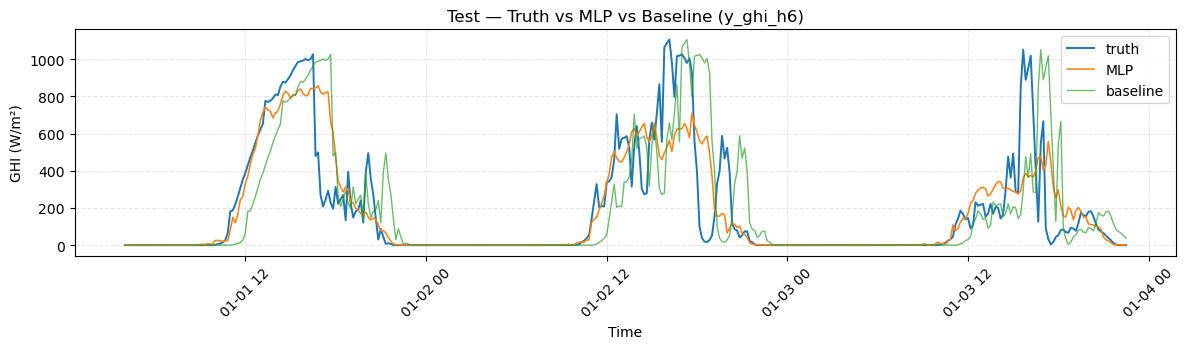

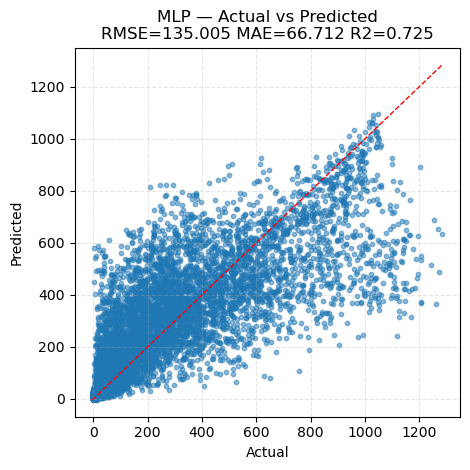

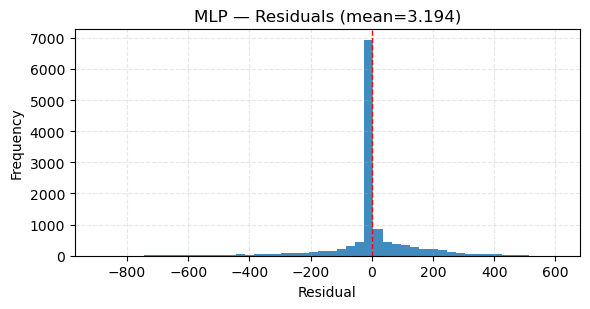


=== LSTM ===
RMSE=137.0326 | MAE=71.6631 | R2=0.7172 | Skill=0.303


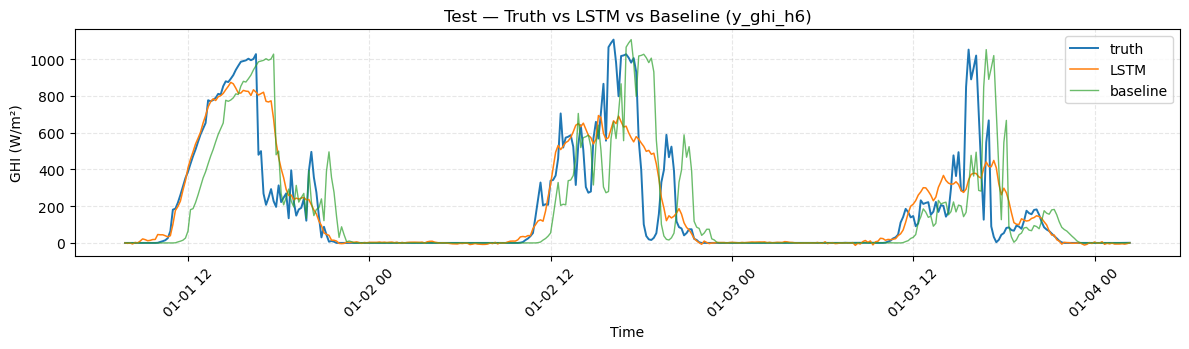

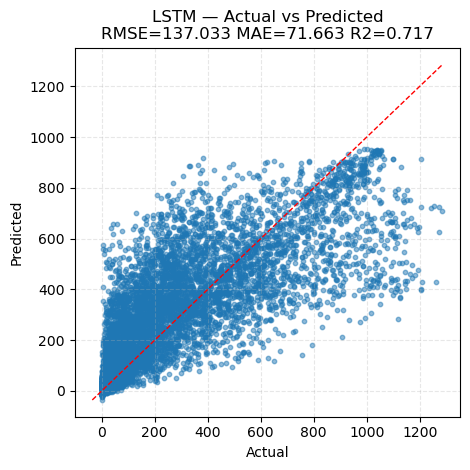

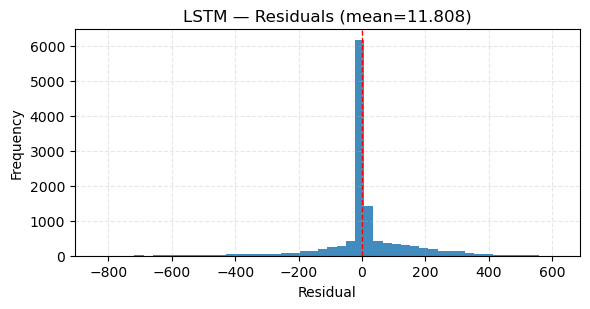


=== BiLSTM ===
RMSE=137.5014 | MAE=71.5644 | R2=0.7152 | Skill=0.300


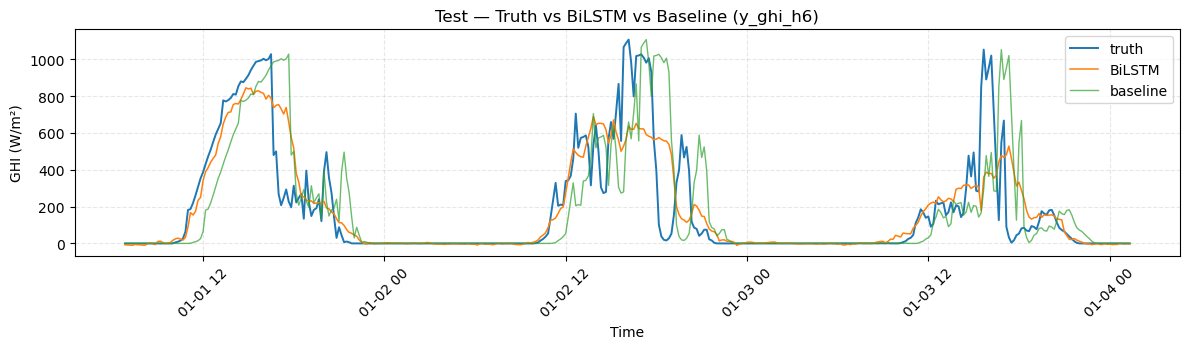

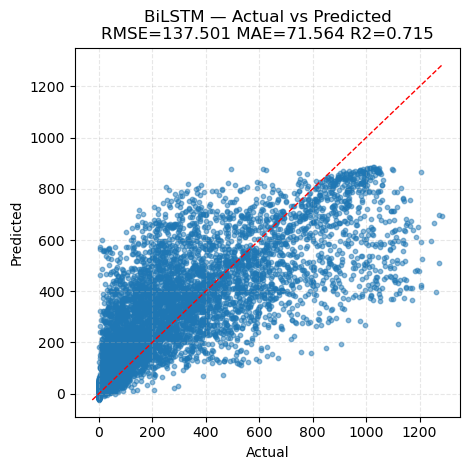

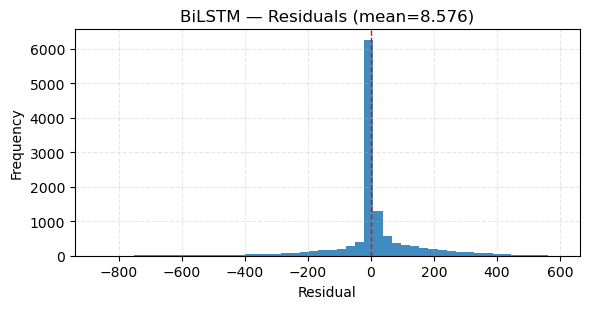


=== CNN-LSTM ===
RMSE=140.1074 | MAE=71.5750 | R2=0.7043 | Skill=0.287


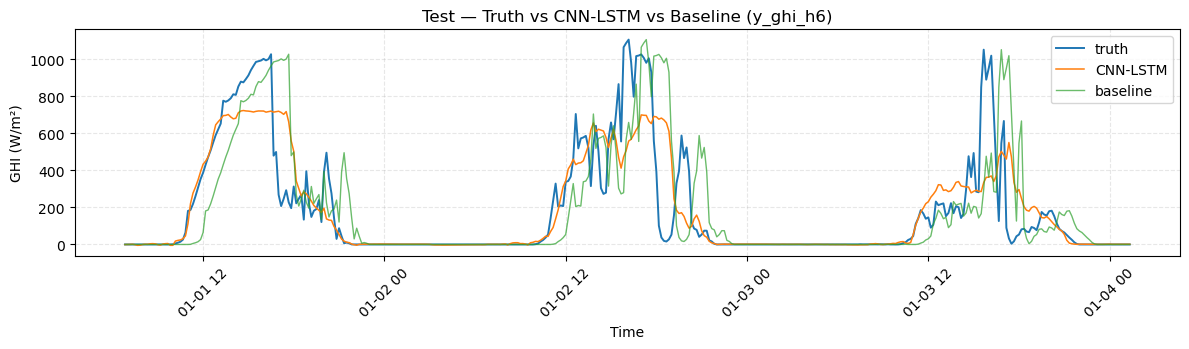

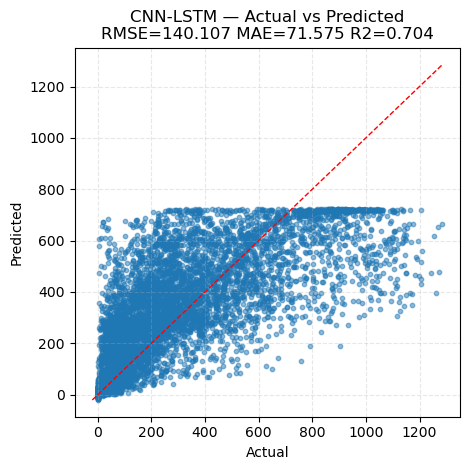

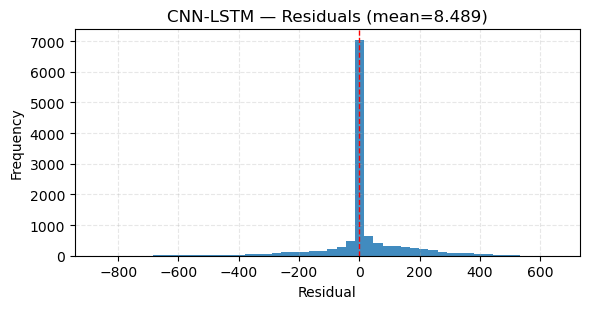


=== Transformer ===
RMSE=139.3382 | MAE=71.9083 | R2=0.7075 | Skill=0.291


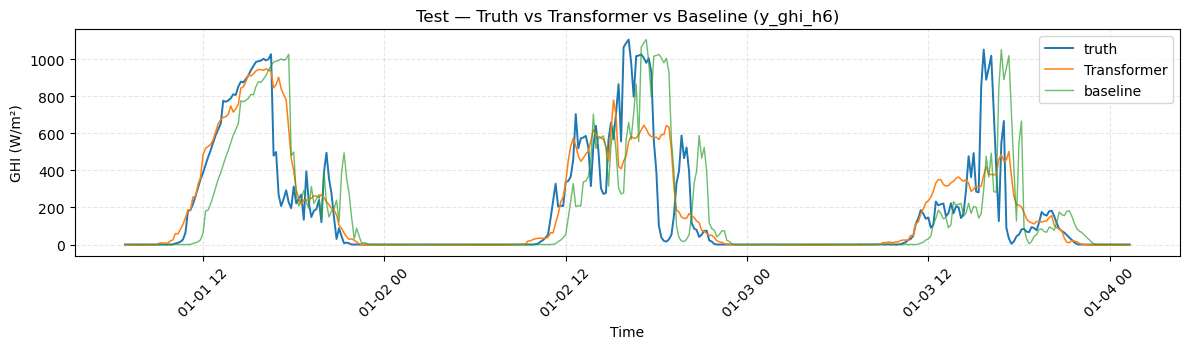

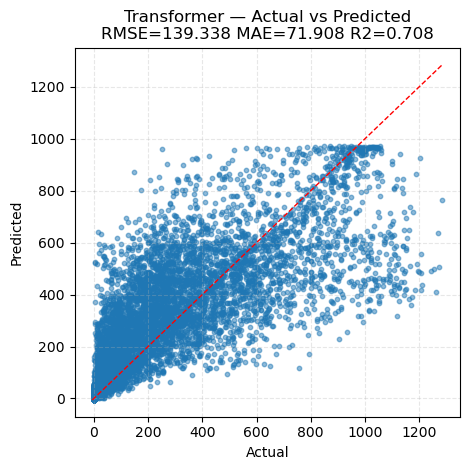

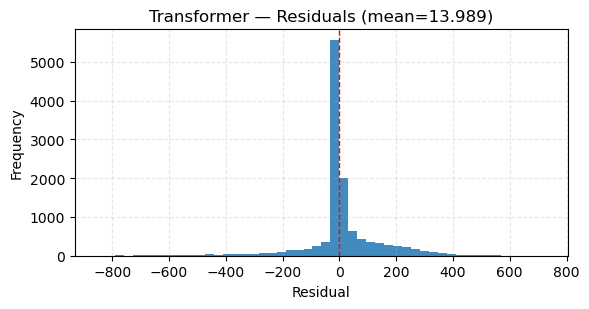

In [24]:
metrics_by_model = {}
hourly_skill_by_model = {}
diag_data = {}

for name, cfg in models_info.items():
    print(f"\n=== {name} ===")
    if cfg["type"] == "tabular":
        y_true = yte
        y_pred = cfg["model"].predict(Xte, verbose=0).squeeze()
        idx    = cfg["idx"]
        yb     = cfg["y_base"]
    else:
        L = int(cfg["L"])
        X_seq, y_seq, idx = build_seq_with_idx(Xte_s, yte, L)
        if len(X_seq) == 0:
            print("No hay secuencias válidas (NaNs). Se omite.")
            continue
        y_true = y_seq
        y_pred = cfg["model"].predict(X_seq, verbose=0).squeeze()
        yb     = pd.Series(y_base, index=Xte_df.index).reindex(idx).to_numpy()

    # Métricas
    mets = compute_metrics(y_true, y_pred, yb)
    metrics_by_model[name] = mets
    print(f"RMSE={mets['RMSE']:.4f} | MAE={mets['MAE']:.4f} | R2={mets['R2']:.4f} | Skill={mets['Skill']:.3f}")

    # Guardar data cruda para diagnósticos adicionales
    diag_data[name] = {
        "y_true": y_true,
        "y_pred": y_pred,
        "idx": idx,
        "y_base": yb,
    }

    # Plots individuales
    plot_ts_clip(idx, y_true, y_pred, yb, name, TARGET, OUT_FIG)
    plot_scatter(y_true, y_pred, name, OUT_FIG)
    plot_residuals(y_true, y_pred, name, OUT_FIG)

    # Skill horario
    sk_hour = hourly_skill(y_true, y_pred, yb, idx)
    hourly_skill_by_model[name] = sk_hour


=== Test Summary (all models, test set) ===
         model      RMSE      MAE      R2   Skill
0          MLP  135.0046  66.7116  0.7252  0.3122
1         LSTM  137.0326  71.6631  0.7172  0.3025
2       BiLSTM  137.5014  71.5644  0.7152  0.3000
4  Transformer  139.3382  71.9083  0.7075  0.2906
3     CNN-LSTM  140.1074  71.5750  0.7043  0.2867
Saved metrics JSON → ../models/hpo_models_test_metrics.json


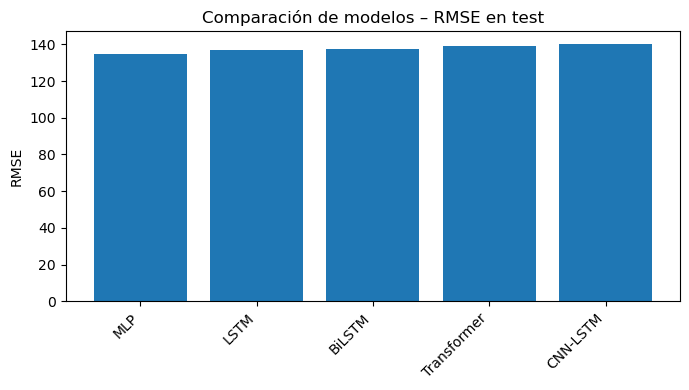

In [25]:
results_df = (
    pd.DataFrame(metrics_by_model)
    .T
    .reset_index()
    .rename(columns={"index": "model"})
    .sort_values("RMSE")
)
print("\n=== Test Summary (all models, test set) ===")
print(results_df.round(4))

# CSV 
results_df.to_csv(OUT_DIR / "hpo_models_test_summary.csv", index=False)

# JSON
metrics_json = {
    m: {k: float(v) for k, v in mets.items()}
    for m, mets in metrics_by_model.items()
}
with open(OUT_DIR / "hpo_models_test_metrics.json", "w") as f:
    json.dump(metrics_json, f, indent=2)
print("Saved metrics JSON →", OUT_DIR / "hpo_models_test_metrics.json")

# Bar plot de RMSE en test
plt.figure(figsize=(7, 4))
plt.bar(results_df["model"], results_df["RMSE"])
plt.ylabel("RMSE")
plt.title("Comparación de modelos – RMSE en test")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.savefig(OUT_FIG / "models_rmse_bar.png", dpi=160)
plt.show()

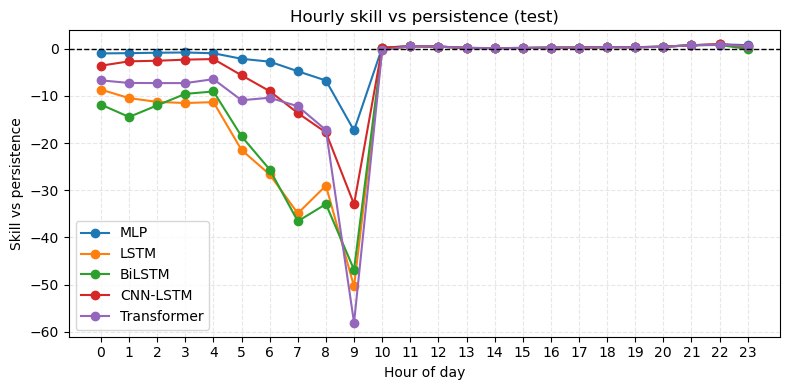

In [26]:
if hourly_skill_by_model:
    plot_hourly_skill_all(hourly_skill_by_model, OUT_FIG)


Mejor modelo por RMSE: MLP


/tmp/ipykernel_676494/3536164500.py:121: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  stats = df_err.groupby("bin").apply(
/tmp/ipykernel_676494/3536164500.py:121: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  stats = df_err.groupby("bin").apply(


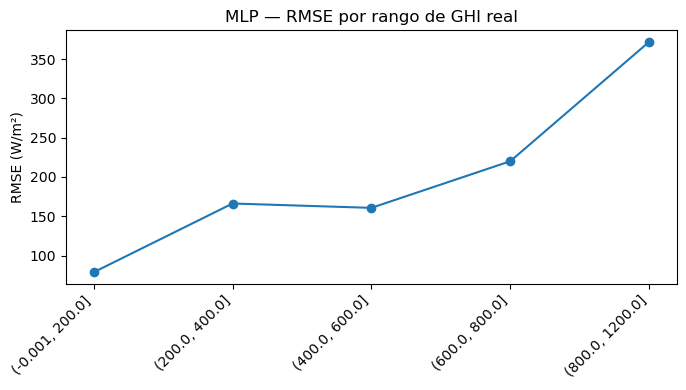

PosixPath('../reports/figures/latest/MLP_rmse_by_ghi_bin.png')

In [27]:
best_model_name = results_df.iloc[0]["model"]
print(f"\nMejor modelo por RMSE: {best_model_name}")
best_diag = diag_data[best_model_name]
plot_binned_rmse(
    best_diag["y_true"],
    best_diag["y_pred"],
    best_model_name,
    OUT_FIG,
    bins=[0, 200, 400, 600, 800, 1200]
)